<a href="https://colab.research.google.com/github/FrattinJuan/SentimentAnalisis/blob/main/TP_Sentiment_Analysis_Frattin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Grupo: Frattin Juan Ignacio

# Preparacion

## Imports

In [ ]:
import re
import pandas as pd
import numpy as np
from nltk.corpus import stopwords

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline


In [ ]:
!pip install textacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 73.7 MB/s eta 0:00:00


In [ ]:
from textacy import preprocessing

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## TextTransform

In [ ]:
"""Text preprocessing module."""

STOPWORDS_SET = set(stopwords.words('english'))
EMOJI_PATTERN = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)


textacy_preproc = preprocessing.make_pipeline(
        preprocessing.normalize.whitespace, #saco espacios en blanco
        preprocessing.remove.accents, #saco acentos
        preprocessing.remove.brackets, #saco los parentesis
        preprocessing.remove.html_tags, #saco los tags
        preprocessing.replace.currency_symbols, #saco los simbolos de moneda
        preprocessing.replace.emails, #los arrobas
        preprocessing.replace.emojis,
        preprocessing.replace.numbers,
        preprocessing.replace.phone_numbers,
        preprocessing.replace.urls,
        preprocessing.replace.user_handles
)

# quitamos las stopwords: palabras que estan en el texto o que no contribuyen significativamente al significado del texto
def remove_stopwords(text):
    """Remove stop words from list of tokenized words."""
    new_words = [word for word in text.split() if word not in STOPWORDS_SET]
    return ' '.join(new_words)
# quitamos los emoticons del texto
def remove_emoticons(text):
    """Remove emoticos."""
    return EMOJI_PATTERN.sub('', text)

#limpiamos todo el texto con los metodos definidos antes
def preprocess_text(text):
    """Preprocess text."""
    clean_text = ""
    clean_text = remove_emoticons(text.lower())
    clean_text = remove_stopwords(clean_text)
    clean_text = textacy_preproc(clean_text)

    return clean_text


PREPROCESS_VECTORIZED = np.vectorize(preprocess_text)


class TextPreProcess(BaseEstimator, TransformerMixin):
    """Text Transformer.

    Perform text preprocessing each text in a list.
    """
    def fit(self, X, y=None):
        """Fit method."""
        return self

    def transform(self, X):
        """Transform input X.

        Args:
            X: array of dictionaries.
        """
        transformed_list = PREPROCESS_VECTORIZED(X)
        return transformed_list

In [ ]:
t = TextPreProcess()

In [ ]:
t.transform(["@spacy_io is OSS for industrial-strength NLP in Python developed by @explosion_ai 💥", "https://test.com es otro ejemplo"])

array(['_USER_ oss industrial-strength nlp python developed _USER_',
       '_URL_ es otro ejemplo'], dtype='<U58')

In [ ]:
t.transform(["este es un() ejemplo DONDE    se sacan varias cosas @hola entre ellas el pepe@gmal.com"])

array(['este es un ejemplo donde se sacan varias cosas _USER_ entre ellas el _EMAIL_'],
      dtype='<U76')

## Modelos y Vectorizadores

In [ ]:
# Generamos variables para nombrar a cada modelo/transformador
LOGISTIC = 'logistic'
NAIVE = 'naive'
TFIDF = 'TFIDF'
COUNT_VEC = 'COUNT_VEC'


VECTORIZER_BY_NAME = {
    TFIDF: TfidfVectorizer(),
    COUNT_VEC: CountVectorizer()
}


MODELS_BY_NAME = {
    LOGISTIC: LogisticRegression(solver='sag', max_iter=10000),
    NAIVE: MultinomialNB()
    # 'SVM':SVM() puedo agregar los modelos que quiera y elegirlos luego
    # 'GB':GradientBoosting()
}

In [ ]:
# Parte complicada e heuristica del TP

def get_pipeline(model_name, vectorizer_name):
    """Retrieve sklearn pipeline."""
    pipeline = Pipeline([
        # normalize
        ('normalize', TextPreProcess()),
        # vectorizer
        ('feats', VECTORIZER_BY_NAME[vectorizer_name]),
        ('model', MODELS_BY_NAME[model_name])
    ])

    return pipeline

In [ ]:
pipeline = get_pipeline(LOGISTIC, TFIDF)

In [ ]:
# pipeline.named_stpes['model']

In [ ]:
pipeline

Pipeline(steps=[('normalize', TextPreProcess()), ('feats', TfidfVectorizer()),
                ('model', LogisticRegression(max_iter=10000, solver='sag'))])

# Explorando la data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/DSA/MÓDULO 06/Trabajo Práctico/yelp.csv")

In [ ]:
df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


## Generando labels

Necesitamos generar dataset de entrenamiento.  
**Cómo conseguimos las clases?**:  Podemos usar las `stars` para dividir nuestro dataset

In [ ]:
df.stars.value_counts()

4    3526
5    3337
3    1461
2     927
1     749
Name: stars, dtype: int64

In [ ]:
df.query('stars ==1').text[:10]

23    U can go there n check the car out. If u wanna...
31    Disgusting!  Had a Groupon so my daughter and ...
35    I've eaten here many times, but none as bad as...
61    I have always been a fan of Burlington's deals...
64    Another night meeting friends here.  I have to...
65    Not busy at all but took nearly 45 min to get ...
71    Yikes, reading other reviews I realize my bad ...
79    This is my first year participating in Arizona...
84    really, I can't believe this place has receive...
89    I was really excited about this event, maybe m...
Name: text, dtype: object

In [ ]:
df.query('stars ==5').text[:10]

0     My wife took me here on my birthday for breakf...
1     I have no idea why some people give bad review...
3     Rosie, Dakota, and I LOVE Chaparral Dog Park!!...
4     General Manager Scott Petello is a good egg!!!...
6     Drop what you're doing and drive here. After I...
9     Nobuo shows his unique talents with everything...
10    The oldish man who owns the store is as sweet ...
11    Wonderful Vietnamese sandwich shoppe. Their ba...
12    They have a limited time thing going on right ...
17    okay this is the best place EVER! i grew up sh...
Name: text, dtype: object

In [ ]:
positives = df.query("stars>=4")
negatives = df.query("stars<=2")
neutral = df.query("stars==3")

In [ ]:
positives.shape

(6863, 10)

In [ ]:
negatives.shape

(1676, 10)

In [ ]:
neutral.shape

(1461, 10)

In [ ]:
#podemos armar una función para clasificar en negativa, positiva, neutra
def get_label(star):
    label = ''
    if star >= 4:
        label = 'positive'
    elif star <= 2:
        label = 'negative'
    else:
        label = 'neutral'
    return label

In [ ]:
# agregamos la calificacion a las reviews, variable categorica
df['label'] = df.stars.apply(get_label)

In [ ]:
df['label'].value_counts()

positive    6863
negative    1676
neutral     1461
Name: label, dtype: int64

Ya tenemos nuestros labels!!

## Feature selection

Seleccionaremos que features usaremos para nuestro modelo

In [ ]:
df.columns

Index(['business_id', 'date', 'review_id', 'stars', 'text', 'type', 'user_id',
       'cool', 'useful', 'funny', 'label'],
      dtype='object')

In [ ]:
dataset = df[['text', 'label']]

## Entrenando modelo binario

In [ ]:
# todas menos las que sean de label neutral
binary_dataset = dataset.query("label!='neutral'")

In [ ]:
binary_dataset

,text,label
0,My wife took me here on my birthday for breakf...,positive
1,I have no idea why some people give bad review...,positive
2,love the gyro plate. Rice is so good and I als...,positive
3,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",positive
4,General Manager Scott Petello is a good egg!!!...,positive
...,...,...
9994,Let's see...what is there NOT to like about Su...,positive
9996,Should be called house of deliciousness!\n\nI ...,positive
9997,I recently visited Olive and Ivy for business ...,positive
9998,My nephew just moved to Scottsdale recently so...,negative


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(binary_dataset['text'], binary_dataset['label'],
                                                    random_state=42, test_size=0.2)

print('Number of rows in the total set: {}'.format(binary_dataset.shape[0]))
print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))

Number of rows in the total set: 8539
Number of rows in the training set: 6831
Number of rows in the test set: 1708


In [ ]:
# Usaremos Logistic con CounVectorizer
pipeline = get_pipeline(LOGISTIC, COUNT_VEC) #probar con varias
pipeline2 = get_pipeline(NAIVE, TFIDF)

In [ ]:
pipeline
pipeline2

Pipeline(steps=[('normalize', TextPreProcess()), ('feats', TfidfVectorizer()),
                ('model', MultinomialNB())])

In [ ]:
pipeline.fit(X_train, y_train)
pipeline2.fit(X_train, y_train)

Pipeline(steps=[('normalize', TextPreProcess()), ('feats', TfidfVectorizer()),
                ('model', MultinomialNB())])

In [ ]:
# prediction
y_pred = pipeline.predict(X_test)
y_pred2 = pipeline2.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

### Evaluacion modelo 1

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="binary", pos_label='positive')
recall = recall_score(y_test, y_pred, average="binary", pos_label='positive')
f1 = f1_score(y_test, y_pred, average="binary", pos_label='positive')
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the results
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')
print('\nConfusion Matrix:')
print(conf_matrix)
print('\nClassification Report:')
print(class_report)


Accuracy: 0.9098360655737705
Precision: 0.9216783216783216
Recall: 0.9691176470588235
F1: 0.9448028673835125

Confusion Matrix:
[[ 236  112]
 [  42 1318]]

Classification Report:
              precision    recall  f1-score   support

    negative       0.85      0.68      0.75       348
    positive       0.92      0.97      0.94      1360

    accuracy                           0.91      1708
   macro avg       0.89      0.82      0.85      1708
weighted avg       0.91      0.91      0.91      1708



### Evaluacion Modelo 2

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred2)
precision = precision_score(y_test, y_pred2, average="binary", pos_label='positive')
recall = recall_score(y_test, y_pred2, average="binary", pos_label='positive')
f1 = f1_score(y_test, y_pred2, average="binary", pos_label='positive')
conf_matrix = confusion_matrix(y_test, y_pred2)
class_report = classification_report(y_test, y_pred2)

# Print the results
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')
print('\nConfusion Matrix:')
print(conf_matrix)
print('\nClassification Report:')
print(class_report)

Accuracy: 0.7968384074941453
Precision: 0.7967193907439953
Recall: 1.0
F1: 0.8868601238995761

Confusion Matrix:
[[   1  347]
 [   0 1360]]

Classification Report:
              precision    recall  f1-score   support

    negative       1.00      0.00      0.01       348
    positive       0.80      1.00      0.89      1360

    accuracy                           0.80      1708
   macro avg       0.90      0.50      0.45      1708
weighted avg       0.84      0.80      0.71      1708



## Graficando la curva de ROC

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

## Modelo 1

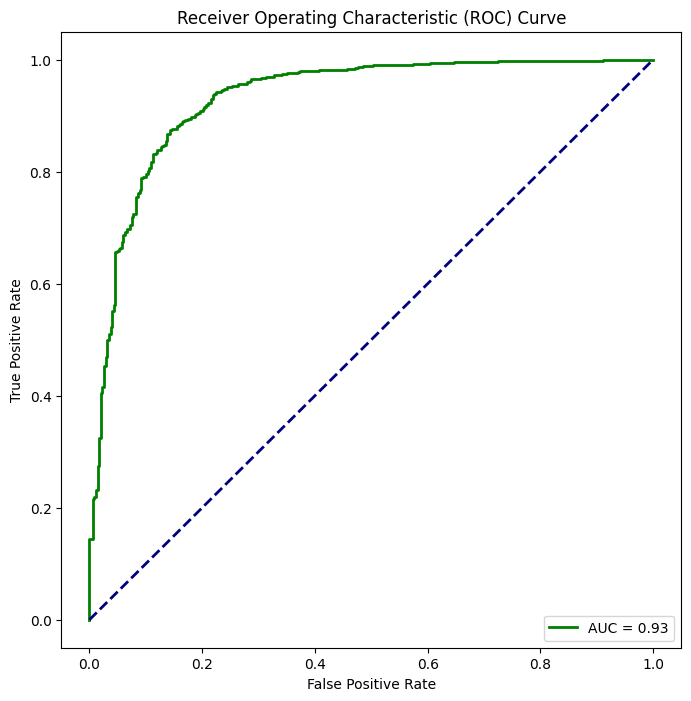

In [ ]:
y_probs = pipeline.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs, pos_label='positive')
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='green', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## Modelo 2

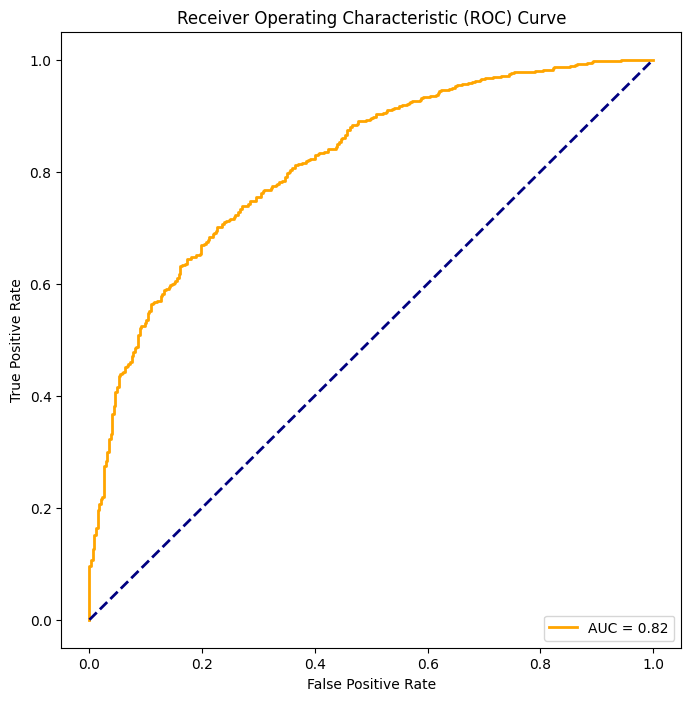

In [ ]:
y_probs = pipeline2.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs, pos_label='positive')
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='orange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Prediccion de las reviews

In [ ]:
!pip install joblib

In [ ]:
import joblib

# Guardar los pipelines
joblib.dump(pipeline, 'pipeline_sentimientos.pkl')
joblib.dump(pipeline2, 'pipeline_sentimientos2.pkl')

# Cargar el pipeline
pipeline_cargado = joblib.load('pipeline_sentimientos.pkl')
pipeline_cargado2 = joblib.load('pipeline_sentimientos2.pkl')

In [ ]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def preprocesar_texto(texto):
    """Realiza el preprocesamiento del texto."""
    texto_procesado = ' '.join([palabra.lower() for palabra in texto.split() if palabra not in ENGLISH_STOP_WORDS])
    return texto_procesado


In [ ]:
nuevo_texto1 = "This restaurant is amazing. The food is delicious and the service is excellent."
nuevo_texto2 = "I am not happy with the quality of service at this place."

# texto_procesado = t.transform([nuevo_texto])
texto_procesado1 = preprocesar_texto(nuevo_texto1)
texto_procesado2 = preprocesar_texto(nuevo_texto2)

# Realizar la predicción con el pipeline cargado

def pred(p):
  if p[0] == 'positive':
    print("El sentimiento del texto es POSITIVO.")
  else:
    print("El sentimiento del texto es NEGATIVO.")

print('modelo1')
pred(pipeline_cargado.predict([texto_procesado1]))
pred(pipeline_cargado.predict([texto_procesado2]))
print('modelo2')
pred(pipeline_cargado2.predict([texto_procesado1]))
pred(pipeline_cargado2.predict([texto_procesado2]))

modelo1
El sentimiento del texto es POSITIVO.
El sentimiento del texto es POSITIVO.
modelo2
El sentimiento del texto es POSITIVO.
El sentimiento del texto es POSITIVO.


In [ ]:
t = "The restaurant is horrible and disgusting"
pred(pipeline_cargado.predict([preprocesar_texto(t)]))
pred(pipeline_cargado2.predict([preprocesar_texto(t)]))

El sentimiento del texto es NEGATIVO.
El sentimiento del texto es NEGATIVO.


In [ ]:
pred(pipeline_cargado.predict([preprocesar_texto("A beautiful and highly recommended restaurant")]))
pred(pipeline_cargado2.predict([preprocesar_texto("A beautiful and highly recommended restaurant")]))

El sentimiento del texto es POSITIVO.
El sentimiento del texto es POSITIVO.


In [ ]:
pred(pipeline_cargado.predict([preprocesar_texto("I spent my birthday there and we had a terrible time!")]))
pred(pipeline_cargado2.predict([preprocesar_texto("I spent my birthday there and we had a terrible time!")]))

El sentimiento del texto es POSITIVO.
El sentimiento del texto es POSITIVO.


# Conclusion

Después de evaluar métricas, el modelo 1 destaca, pero al hacer predicciones manuales, ambos modelos muestran resultados idénticos y comparten las mismas limitaciones. Se sugiere explorar un conjunto más amplio de revisiones para mejorar la capacidad de generalización. Aunque las métricas respaldan al modelo 1, la práctica revela desafíos comunes. La expansión del conjunto de datos es esencial para lograr modelos más robustos en la predicción de revisiones.